1. **Import library**

    First thing first is to import the needed libraries: 
- pandas library will be used to preprocess the data and generate appropriate dataframes
- numpy can identify the sentiment number therefore to differentiate the line color
- netoworkx functions to connect the network lines between Twitter users
- matplotlib is used as basic tool to draw (pyplot to plot the picture, lines to draw legend's line)
- basemap to draw the map of The Netherlands

In [1]:
# import libraries
import pandas as pd
import numpy as np
import networkx as nx
import ast
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines

2. **Data preparation**

    This part is to prepare the dataframes for network visualization in the next part. Outcomes will be user-interaction dataframes for three different types of sentiment (positive: gfp_po, neutral: gfp_neu, negative: gfp_neg), as well as user-location dataframes (pos_data_po, pos_data_neu, pos_data_neg). 

In [2]:
# import spatial and sentiment Twitter data
tweetsGEO = pd.read_csv('tw_g.csv')
tweetsNLP = pd.read_csv('tw_s.csv')

# merge them into one dataframe
tweets = pd.merge(tweetsGEO, tweetsNLP, on='id', right_index=False, left_index=False)

# add count and average sentiment_num
tweets['count'] = tweets.groupby(['author_id', 'in_reply_to_user_id']).author_id.transform(lambda x: x.count())
tweets['sentiment_avg'] = tweets.groupby(['author_id', 'in_reply_to_user_id']).sentiment_num.transform(lambda x: x.mean())

# check the tweets dataframe structure
tweets.head()

,id,author_id,text_x,conversation_id,in_reply_to_user_id,sender_location,receiver_location,Unnamed: 0,text_y,sentiment,sentiment_num,count,sentiment_avg
0,1641769213462302721,21298074,@mirjamlederwerg Ik geloof het wel.,1641455728958357506,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0,@mirjamlederwerg Ik geloof het wel.,neutral,0.0,2,0.0
1,1641769076153368578,21298074,@mirjamlederwerg Die ken ik hier niet.,1641720811701653504,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",1,@mirjamlederwerg Die ken ik hier niet.,neutral,0.0,2,0.0
2,1641765800250843136,143788349,@MisterSenseo @MilfHummie Heel stom! Als ik we...,1641526240451371031,365677125,"[4.6750992, 51.9056092, 4.8323339, 51.9841161]","[4.1903465, 52.0148713, 4.4224441, 52.1388646]",2,@MisterSenseo @MilfHummie Heel stom! Als ik we...,positive,0.5,2,0.5
3,1641760234489167873,123950495,@merchandise @SaschaJanssen @JaapFriso @MerelM...,1641442842055938049,7167342,"[5.7576521, 51.7905544, 5.9082602, 51.8947409]","[5.1830769, 51.3055699, 5.3137105, 51.4365525]",3,@merchandise @SaschaJanssen @JaapFriso @MerelM...,neutral,0.0,3,0.0
4,1641756738385854465,940899377543110656,@Pieterjanvl Maar ik was dus Vlaanderen aan he...,1641726576650772481,48287280,"[5.2121062, 50.8677279, 5.4145591, 50.9815265]","[4.774005, 50.9533704, 4.9369701, 51.0376519]",4,@Pieterjanvl Maar ik was dus Vlaanderen aan he...,neutral,0.0,1,0.0


In [3]:
# split bounding box into longtitude and latitude
# define the spliting function 
def compute_central_point(bbox):
    # extract the bounding box coordinates
    xmin, ymin, xmax, ymax = bbox

    # compute the central point coordinates
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    return x_center, y_center

def parse_coordinates(s):
    return ast.literal_eval(s)

def box_to_point(input_tweets, colum_send, colum_rec):
    #cChange Type of Columns by applying the parse_coordinates function on all rows
    input_tweets['sender_location'] = input_tweets['sender_location'].apply(parse_coordinates)
    input_tweets['receiver_location'] = input_tweets['receiver_location'].apply(parse_coordinates)

    # transform bounding boxes to central point locations
    input_tweets[colum_send] = input_tweets[colum_send].apply(compute_central_point)
    input_tweets[colum_rec] = input_tweets[colum_rec].apply(compute_central_point)
    return input_tweets

# define a function to split the tuples into two columns
def split_tuple(row):
    return pd.Series({'longitudeSend': row[0], 'latitudeSend': row[1]})

def split_tuple2(row):
    return pd.Series({'longitudeRec': row[0], 'latitudeRec': row[1]})

# call function 
box_to_point(tweets, 'sender_location', 'receiver_location')

# apply the function to the column and join the result with the original dataframe
tweets = tweets.join(tweets['sender_location'].apply(split_tuple))
tweets = tweets.join(tweets['receiver_location'].apply(split_tuple2))

In [4]:
# divide tweets into three different kinds of sentiment
gfp_po = tweets[tweets['sentiment_avg'] > 0]
gfp_neg= tweets[tweets['sentiment_avg'] < 0]
gfp_neu= tweets[tweets['sentiment_avg'] == 0]

# have a look at one of the three dataframes
gfp_po.head()

,id,author_id,text_x,conversation_id,in_reply_to_user_id,sender_location,receiver_location,Unnamed: 0,text_y,sentiment,sentiment_num,count,sentiment_avg,longitudeSend,latitudeSend,longitudeRec,latitudeRec
2,1641765800250843136,143788349,@MisterSenseo @MilfHummie Heel stom! Als ik we...,1641526240451371031,365677125,"(4.75371655, 51.944862650000005)","(4.3063953, 52.07686795)",2,@MisterSenseo @MilfHummie Heel stom! Als ik we...,positive,0.5,2,0.5,4.753717,51.944863,4.306395,52.076868
6,1641724030901207041,1635231487153827842,@petor76 Goed werk! Gelukkig is er nog vrijhei...,1641652627875217410,20969469,"(4.6176119, 51.9995256)","(4.8521976, 52.2862412)",6,@petor76 Goed werk! Gelukkig is er nog vrijhei...,very positive,1.0,1,1.0,4.617612,51.999526,4.852198,52.286241
7,1641713769037324290,1621056067642736642,@sanderoord Nog nooit iets van gemerkt! Ik dac...,1641693975751925761,149469986,"(4.612501399999999, 51.8240858)","(4.3063953, 52.07686795)",7,@sanderoord Nog nooit iets van gemerkt! Ik dac...,positive,0.5,2,0.5,4.612501,51.824086,4.306395,52.076868
15,1641557382252621829,133265773,"@margotlantinga Och nee, Margot...wat een tege...",1641438030933422080,111625233,"(5.388298649999999, 52.02860325)","(5.082766749999999, 52.084189949999995)",15,"@margotlantinga Och nee, Margot...wat een tege...",positive,0.5,1,0.5,5.388299,52.028603,5.082767,52.084190
18,1641545817193365507,102107308,@RaymondTans Ja ik las dat ze dag dat de brief...,1641521426481008641,321385973,"(-0.48623854999999994, 39.3501604)","(-8.736367699999999, 37.15320385)",18,@RaymondTans Ja ik las dat ze dag dat de brief...,positive,0.5,1,0.5,-0.486239,39.350160,-8.736368,37.153204


In [5]:

# define a function to create location dataframe
def pos(gfp):
    pos_data_1 = gfp.loc[:, ['author_id', 'longitudeSend', 'latitudeSend', 'count']].rename(
    columns={'author_id': 'user_id', 'longitudeSend': 'Long', 'latitudeSend': 'Lat','count': 'count'})
    pos_data_2=pd.DataFrame()
    pos_data_2 = gfp.loc[:, ['in_reply_to_user_id', 'longitudeRec', 'latitudeRec', 'count']].rename(
    columns={'in_reply_to_user_id': 'user_id', 'longitudeRec': 'Long', 'latitudeRec': 'Lat','count': 'count'})
    
    # create a dataframe including both sender and receiver's location info
    pos_data = pd.concat([pos_data_1, pos_data_2])
    
    # define the boundaries of the Netherlands
    nl_lon_min, nl_lat_min = 3.2, 50.7
    nl_lon_max, nl_lat_max = 7.4, 53.6

    # filter the data to only include points within the Netherlands boundaries
    pos_data = pos_data[(pos_data['Long'] >= nl_lon_min) & (pos_data['Long'] <= nl_lon_max) &
                        (pos_data['Lat'] >= nl_lat_min) & (pos_data['Lat'] <= nl_lat_max)]    

    return pos_data

# call location dataframe making function
pos_data_po=pos(gfp_po)
pos_data_neg=pos(gfp_neg)
pos_data_neu=pos(gfp_neu)

3. **Data visualization**

    In this part, a function to visualize the interactions between people on Twitter within The Netherlands willbe defined. By calling the function, network drawings will be derived from three dataframe groups. 

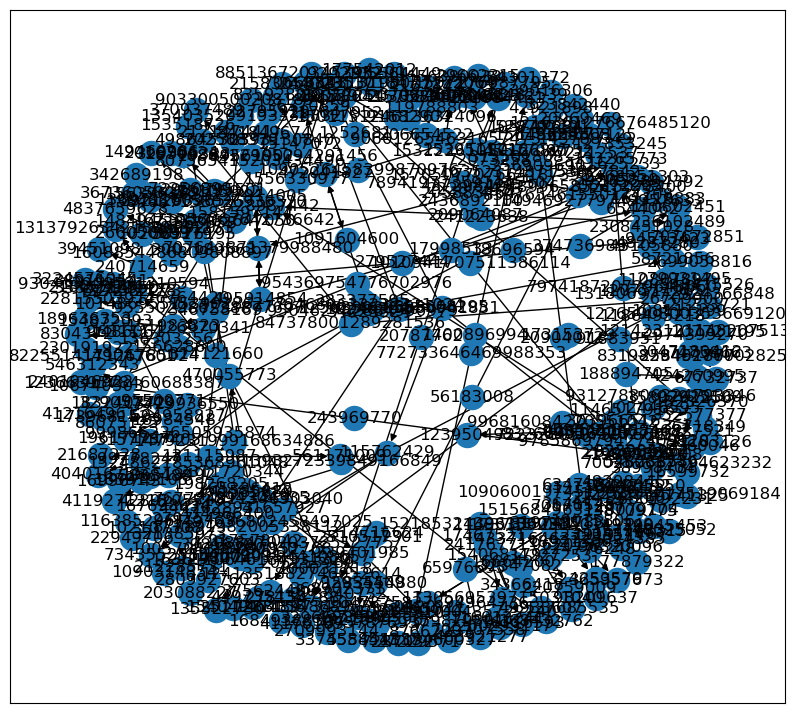

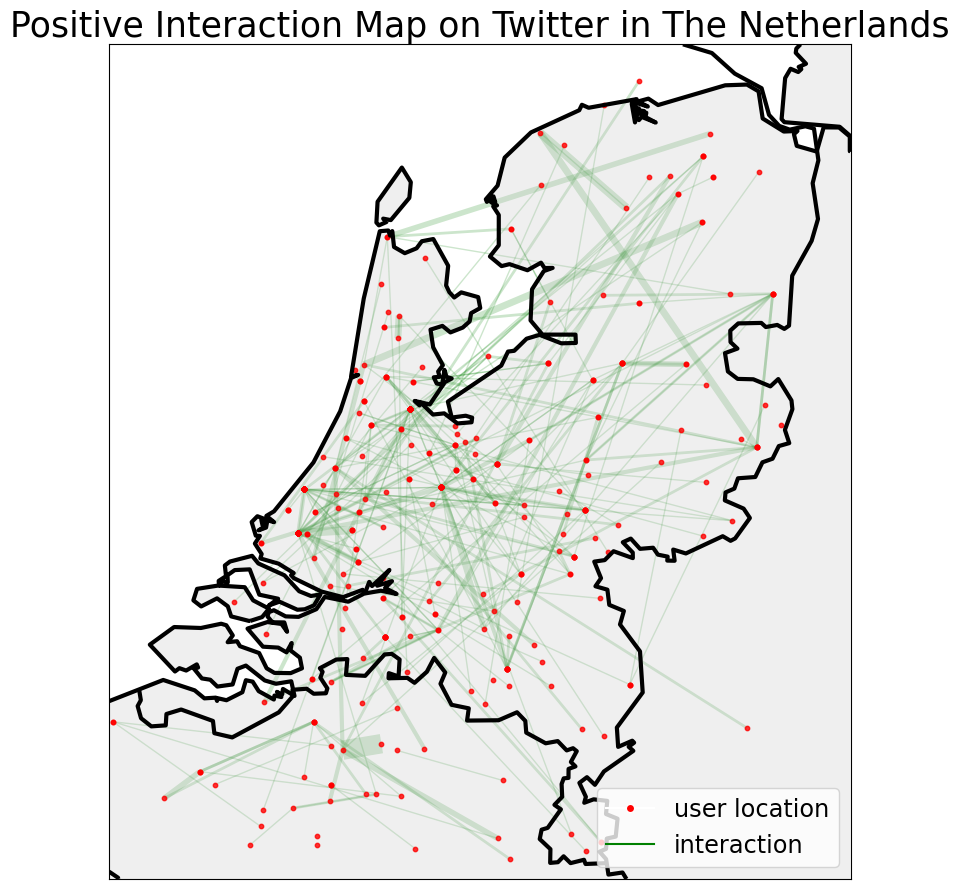

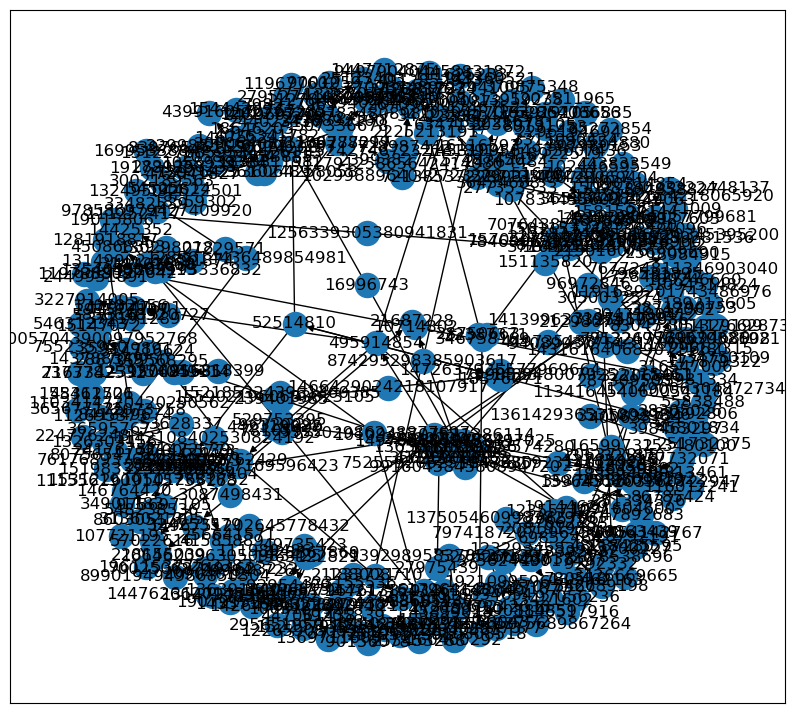

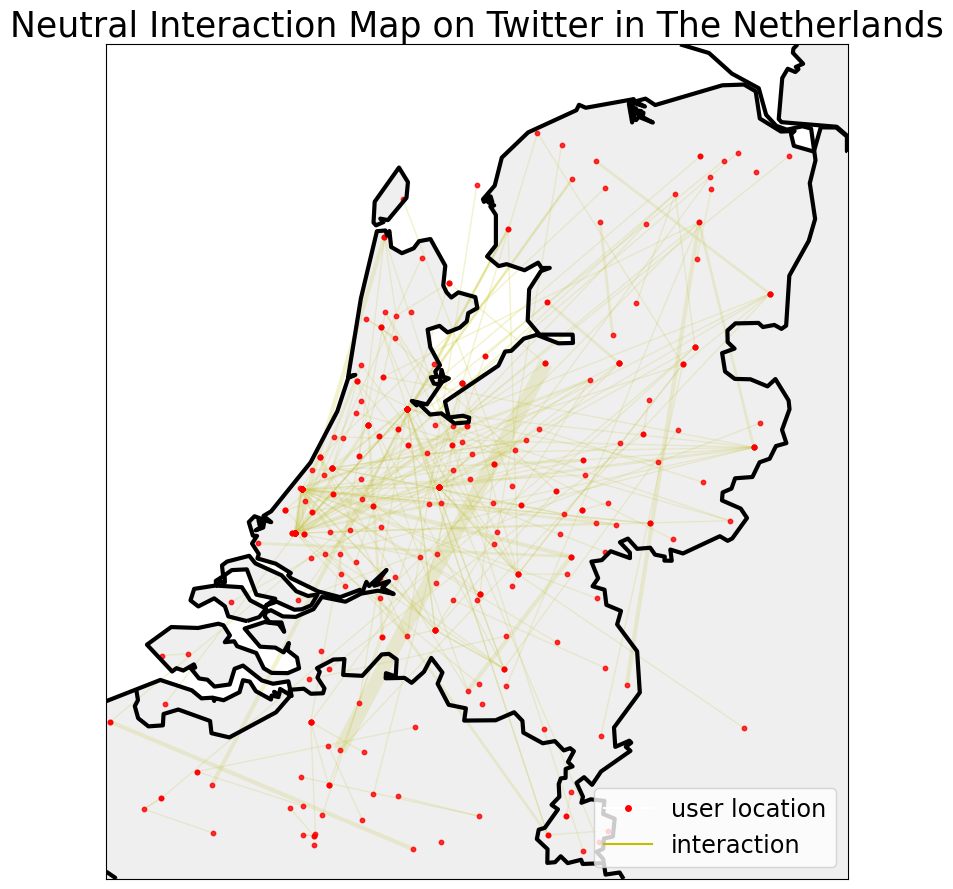

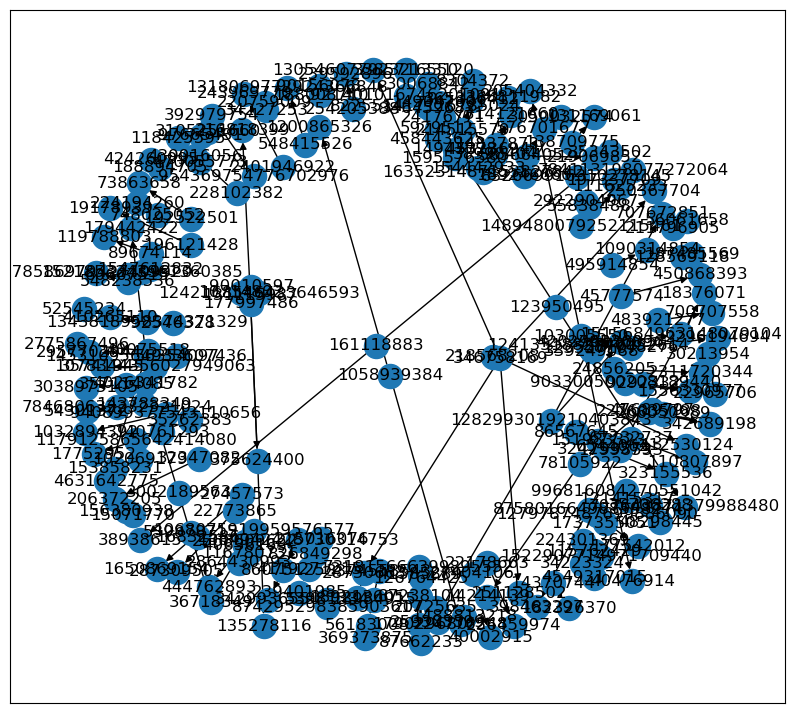

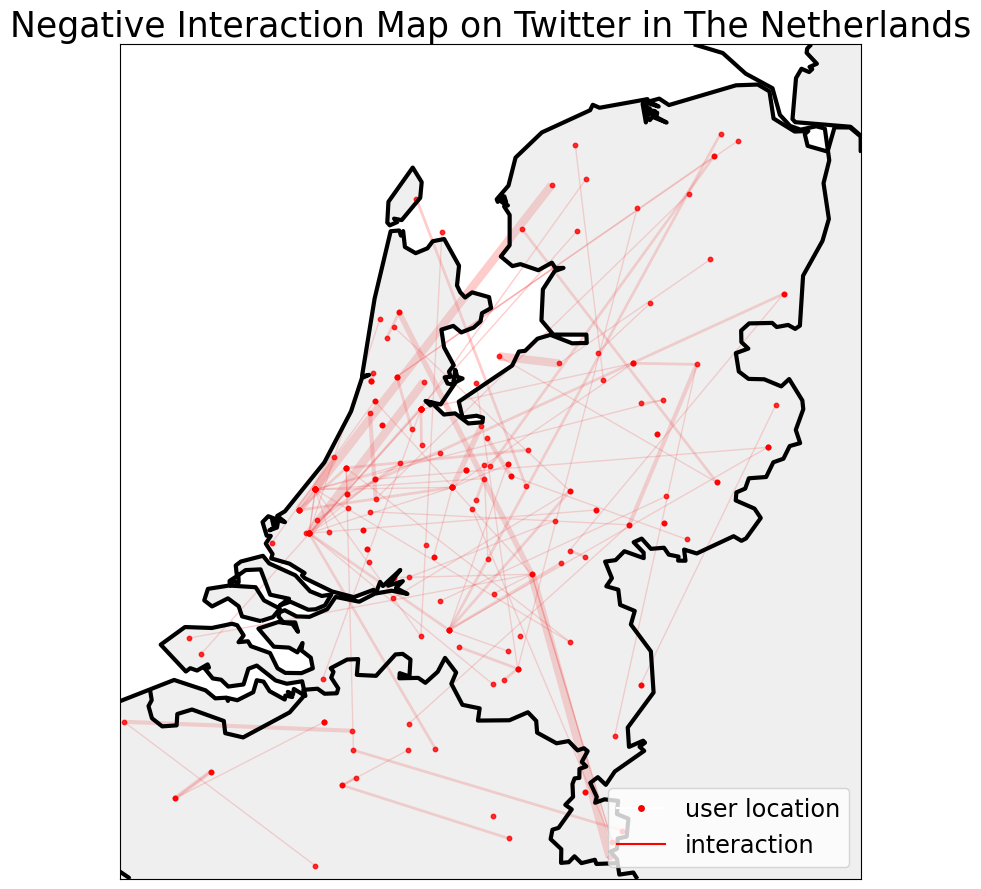

In [28]:
def visualization(gfp, pos_data):
    # use networkx to draw
    graph = nx.from_pandas_edgelist(gfp, source='author_id', target='in_reply_to_user_id', edge_attr='count', create_using=nx.DiGraph())
    plt.figure(figsize=(10,9))
    nx.draw_networkx(graph)

    # classfy different characteristics of plots by sentiment
    if gfp['sentiment_avg'].mean() > 0:
        title = "Positive Interaction Map on Twitter in The Netherlands"
        pic = " po"
        colors = "g"
    elif gfp['sentiment_avg'].mean() == 0:
        title = "Neutral Interaction Map on Twitter in The Netherlands"
        pic = " neu"
        colors = "y"
    else:
        title = "Negative Interaction Map on Twitter in The Netherlands"
        pic = " neg"
        colors = "r"

    # set Basemap of the Netherlands
    plt.figure(figsize=(10,9))
    m = Basemap(projection='merc', 
                llcrnrlon=3.2, 
                llcrnrlat=50.7, 
                urcrnrlon=7.4, 
                urcrnrlat=53.6,
                lat_ts=0,
                resolution='i',
                suppress_ticks=True)

    # project users' positions on Basemap
    mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
    pos = {}
    for count, elem in enumerate(pos_data['user_id']):
        pos[elem] = (mx[count], my[count])

    # get nodes missing from pos dictionary
    missing_nodes = set(graph.nodes()).difference(set(pos.keys()))

    # remove missing nodes from graph
    graph.remove_nodes_from(missing_nodes)

    # create list of edge widths based on the count column
    edge_widths = [d['count'] for u, v, d in graph.edges(data=True)]

    # draw edges with color and width
    nx.draw_networkx_edges(graph, pos=pos, edge_color=colors, alpha=0.2, arrows=False, width=edge_widths)

    # draw nodes with size based on count column
    nx.draw_networkx_nodes(graph, pos=pos, node_color='r', alpha=0.8, node_size=10)

    # draw the boundary of The Netherlands
    m.drawcountries(linewidth=3)
    m.drawstates(linewidth=0.2)
    m.drawcoastlines(linewidth=3)
    m.fillcontinents(alpha = 0.3)

    # draw the legend 
    line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
    line2 = mlines.Line2D(range(1), range(1), color=colors, marker='',markerfacecolor=colors)
    plt.legend((line1, line2), ('user location', 'interaction'), loc=4, fontsize = 'xx-large')

    # plot the visualization results (as different titles and name)

    plt.title(title, fontsize = 25)
    plt.tight_layout()
    plt.savefig(f"./images/networkx/map_{pic.lower().replace(' ', '_')}.png", format = "png", dpi = 300)
    plt.show()

# call function with the desired gfp dataframe and pos_data dataframe
visualization(gfp_po, pos_data_po)
visualization(gfp_neu, pos_data_neu)
visualization(gfp_neg, pos_data_neg)
